# Stochastic Gradient Descent Classifiers
## Hyperparameter tuning with grid search and cross-validation

<img src="../images/SGD.jpg" width="500">

**Stochastic Gradient Descent (SGD)** is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) **Support Vector Machines** and **Logistic Regression**. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.
<br>
<br>
SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features.
<br>
The advantages of Stochastic Gradient Descent are:
* Efficiency.
* Ease of implementation (lots of opportunities for code tuning).

The disadvantages of Stochastic Gradient Descent include:
* SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
* SGD is sensitive to feature scaling.

## Import Python Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

## Import Utility Classes

In [2]:
%autoreload 2
import sys
sys.path.append('..')

from utils.data_loader import DataLoader
from utils.term_counter_helper import TermFrequency, TfIdf
from utils.data_frame_helper import DataFrameHelper
from utils.model_evaluation_helper import ModelEvaluationHelper
from utils.classifier_helper import Classifier

## Load Data

In [3]:
loader = DataLoader()
content = loader.load_data("../Data/trainingdata.txt")

Number of Rows:  5485



In [4]:
label_names = np.array(["A", "B", "C", "D", "E", "F", "G", "H"])
df = loader.get_data_frame(content, label_names)
df_helper = DataFrameHelper(df, label_names)

5485 documents
8 categories


## Input Dataset in DataFrame Format

In [5]:
df_helper.df.head()

,Labels,Text
0,A,champion products ch approves stock split cham...
1,B,computer terminal systems cpml completes sale ...
2,A,cobanco inc cbco year net shr cts vs dlrs net ...
3,A,am international inc am nd qtr jan oper shr lo...
4,A,brown forman inc bfd th qtr net shr one dlr vs...


## Term Frequency Featurization

In [6]:
min_df = 2

tf = TermFrequency(
    label_names,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words='english',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=0.8,
    min_df = min_df,
    max_features=None,
    vocabulary=None)

tf.vectorize_corpus(df_helper.raw_text)
tf.vectorizer

Feature Matrix:
n_samples: 5485 
n_features: 10416


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

## Split Dataset into Trainset and Testset

In [7]:
tf_model_evaluation = ModelEvaluationHelper(
    tf.X, df_helper.y, test_size=0.3, random_state=3,
    label_names = df_helper.label_names,
    feature_names = tf.vectorizer.get_feature_names())

Number of observations in Train: 3839
Number of observations in Test : 1646


## SGD Classifier Implementation
Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
<br>
This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.
<br>
<br>
The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). If the parameter update crosses the 0.0 value because of the regularizer, the update is truncated to 0.0 to allow for learning sparse models and achieve online feature selection.

## Select Hyperparameter Range for Gird Search

In [8]:
hyperparameters = {
    'alpha': (1e-04, 1e-05, 1e-06),
    'penalty': ('l2',  'l1', 'elasticnet'),
}

## Scoring Metric Available

* scores: 
    * *accuracy, precision_weighted, recall_weighted, f1_weighted, auc_roc*

## Linear SVM
<img src="../images/learnSVM.png" width="500">

## Run Grid Search with Cross Validation

In [9]:
tf_model_evaluation.set_hyperparam_grid(hyperparameters)
clf = Classifier()

In [10]:
linearSVM = clf.multinomial_SGD_clf(
    "linearSVM", n_iter=10, shuffle=True, learning_rate='optimal', class_weight="balanced", average=False)
tf_model_evaluation.cross_val_grid_search(linearSVM, "f1_weighted", cv = 5, iid=True)


* Cross-Validation & Grid Search

Fitting 5 folds for each of 9 candidates, totalling 45 fits

* Matrix Sparsity

dimensionality: 10416
density: 0.342166

* Feature Importants

top 10 keywords per class:
A: sees, costs, distribution, vs, expects, profits, profit, dividend, results...
B: buy, vtx, savings, purchase, acquired, takeover, acquisition, stake, merge...
C: subsidies, wine, production, like, countries, eep, export, soviet, exports...
D: south, employers, sector, workers, capacity, cargo, ships, port, yards, sh...
E: elevator, crop, winter, agriculture, grains, certificates, case, floor, ce...
F: petroleum, chevron, revenue, drilling, fields, crude, field, prt, refinery...
G: quarter, term, prime, point, recent, half, debt, cut, rate, rates
H: employment, economists, currencies, treasury, sudan, market, exchange, mon...


* Best Model Results

Best score: 0.961
Best parameters set:
	alpha: 1e-05
	penalty: 'l2'

* Grid Search

Grid scores on training set:

0.958 (+/-0.014) for 

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.2s finished


## Confusion Matrix

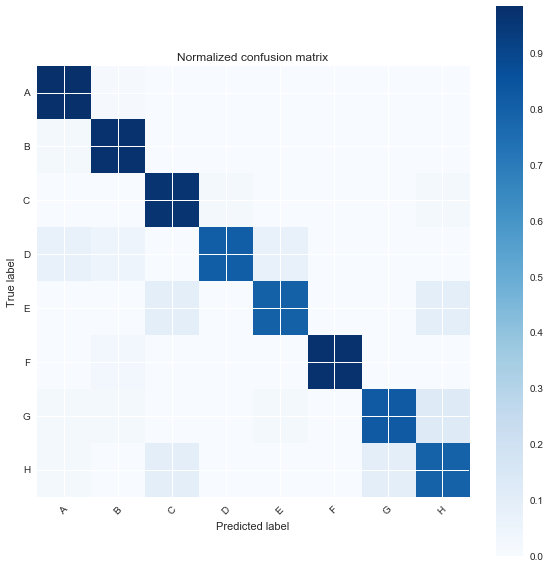

In [11]:
tf_model_evaluation.confusion_matrix()

## TF-IDF Featurization

In [12]:
min_df = 2

tfidf = TfIdf(
    label_names,
    norm='l2',
    smooth_idf = True,
    sublinear_tf = False,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words='english',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=0.8,
    min_df = min_df,
    max_features=None,
    vocabulary=None)

tfidf.vectorize_corpus(df_helper.raw_text)
tfidf.vectorizer

Feature Matrix:
n_samples: 5485 
n_features: 10416


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

## Split Dataset into Trainset and Testset

In [13]:
tfidf_model_evaluation = ModelEvaluationHelper(
    tfidf.X, df_helper.y, test_size=0.3, random_state=3,
    label_names = df_helper.label_names,
    feature_names = tfidf.vectorizer.get_feature_names())

Number of observations in Train: 3839
Number of observations in Test : 1646


## Linear SVM: Run Grid Search with Cross Validation

In [14]:
tfidf_model_evaluation.set_hyperparam_grid(hyperparameters)

linearSVM = clf.multinomial_SGD_clf(
    "linearSVM", n_iter=10, shuffle=True, learning_rate='optimal', class_weight="balanced", average=False)
tfidf_model_evaluation.cross_val_grid_search(linearSVM, "f1_weighted", cv = 5)


* Cross-Validation & Grid Search

Fitting 5 folds for each of 9 candidates, totalling 45 fits

* Matrix Sparsity

dimensionality: 10416
density: 0.140157

* Feature Importants

top 10 keywords per class:
A: loss, net, profits, cts, profit, results, vs, earnings, split, dividend
B: purchase, offer, buy, assets, acquired, acquire, sell, acquisition, merger...
C: japanese, import, japan, sanctions, moscow, soviet, goods, export, exports...
D: vessel, freights, vessels, workers, dead, strike, mt, port, ships, shipping
E: agriculture, tonnes, crop, farm, harvest, winter, elevator, gao, intervent...
F: pancanadian, indonesia, bbl, barrels, exploration, drilling, opec, crude, ...
G: room, little, tomorrow, borrowings, bundesbank, customer, pct, prime, rate...
H: ems, day, market, money, dollars, currencies, monetary, exchange, dollar, ...


* Best Model Results

Best score: 0.970
Best parameters set:
	alpha: 0.0001
	penalty: 'elasticnet'

* Grid Search

Grid scores on training set:

0.969 (+

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.0s finished


## Confusion Matrix

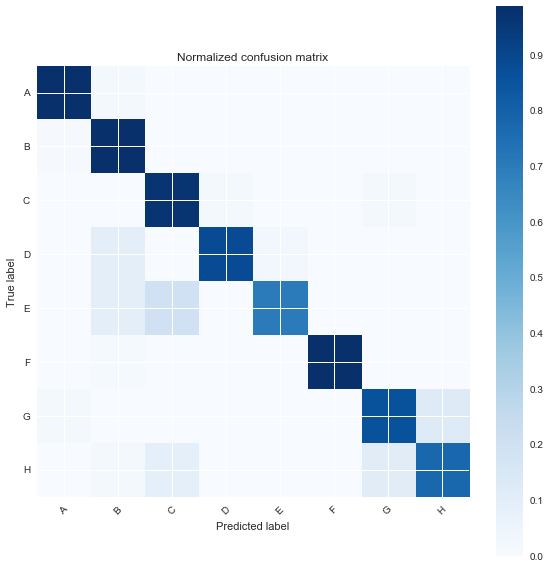

In [15]:
tfidf_model_evaluation.confusion_matrix()

## Logistic Regression
Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.
<br>
<br>
This implementation can fit a multiclass (one-vs-rest) logistic regression with optional L2 or L1 regularization.
<br>
<br>
As an optimization problem, binary class $L2$ penalized logistic regression minimizes the following cost function:
$$\underset{w, c}{min\,} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .$$
Similarly, $L1$ regularized logistic regression solves the following optimization problem
$$\underset{w, c}{min\,} \|w\|_1 + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .$$

In [16]:
logisticRegression = clf.multinomial_SGD_clf(
    "logisticRegression", n_iter=10, shuffle=True, learning_rate='optimal', class_weight="balanced", average=False)
tfidf_model_evaluation.cross_val_grid_search(logisticRegression, "f1_weighted", cv = 5)


* Cross-Validation & Grid Search

Fitting 5 folds for each of 9 candidates, totalling 45 fits

* Matrix Sparsity

dimensionality: 10416
density: 0.973502

* Feature Importants

top 10 keywords per class:
A: results, year, net, profits, profit, earnings, cts, split, vs, dividend
B: purchase, vtx, acquired, offer, buy, acquire, sell, acquisition, merger, s...
C: ec, imports, soviet, deficit, japan, japanese, export, goods, exports, trade
D: container, missiles, mt, strike, vessel, seaway, cranes, port, ships, ship...
E: dissolution, intervention, crops, crop, farm, amstutz, certificates, coope...
F: petrobras, petroleum, bbl, drilling, barrels, exploration, opec, refinery,...
G: debt, tomorrow, bundesbank, little, room, customer, pct, prime, rates, rate
H: treasury, dollars, market, fed, money, currencies, monetary, exchange, cur...


* Best Model Results

Best score: 0.970
Best parameters set:
	alpha: 1e-05
	penalty: 'l2'

* Grid Search

Grid scores on training set:

0.960 (+/-0.017) f

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.9s finished


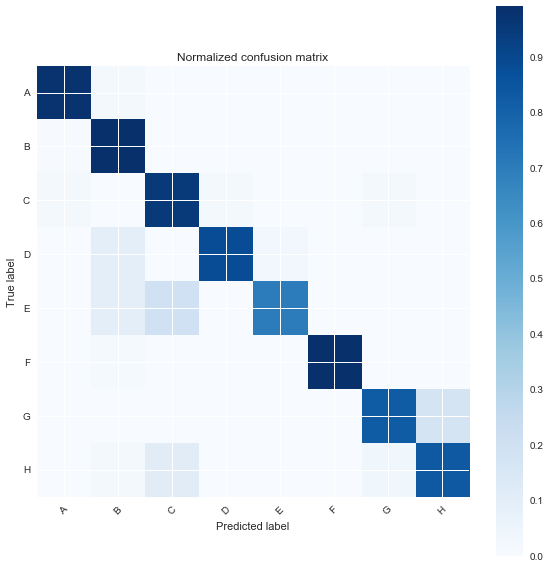

In [17]:
tfidf_model_evaluation.confusion_matrix()

## Perceptron
The Perceptron is another simple algorithm suitable for large scale learning.
By default:
* It does not require a learning rate.
* It is not regularized (penalized).
* It updates its model only on mistakes.

The last characteristic implies that the Perceptron is slightly faster to train than SGD with the hinge loss and that the resulting models are sparser.

In [18]:
perceptron = clf.multinomial_SGD_clf(
    "perceptron", n_iter=10, shuffle=True, learning_rate='optimal', class_weight="balanced", average=False)
tfidf_model_evaluation.cross_val_grid_search(perceptron, "f1_weighted", cv = 5)


* Cross-Validation & Grid Search

Fitting 5 folds for each of 9 candidates, totalling 45 fits

* Matrix Sparsity

dimensionality: 10416
density: 0.308480

* Feature Importants

top 10 keywords per class:
A: distribution, profits, cts, results, profit, vs, earnings, split, gain, di...
B: merger, buy, acquired, vtx, acquire, assets, stake, acquisition, sell, coa...
C: stephens, yugoslav, exports, volcker, wine, soviet, agriculture, moscow, e...
D: strike, iranian, missiles, lease, port, cranes, ships, tanker, shipping, mt
E: farm, winterkill, winter, amstutz, crop, certificates, grains, floor, grai...
F: drilling, pancanadian, eia, rigs, canterra, north, bbl, crude, refinery, oil
G: gros, danish, tomorrow, debt, pct, mo, bundesbank, customer, rates, rate
H: stg, peso, currencies, day, exchange, dollar, currency, fed, repurchases, ...


* Best Model Results

Best score: 0.961
Best parameters set:
	alpha: 1e-06
	penalty: 'l2'

* Grid Search

Grid scores on training set:

0.953 (+/-0.015) 

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.8s finished


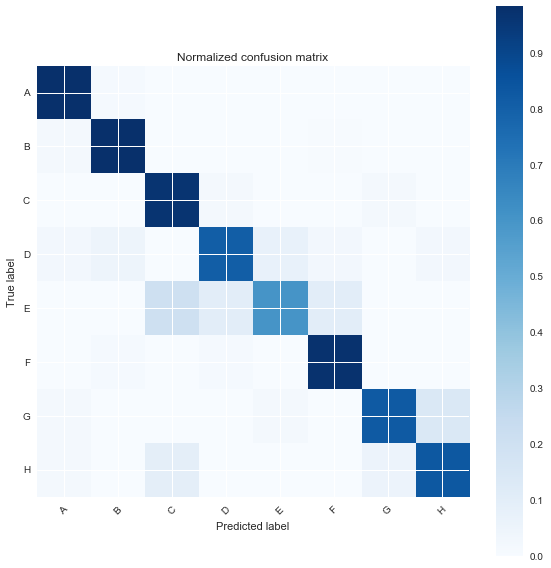

In [19]:
tfidf_model_evaluation.confusion_matrix()

## Modified Huber Loss

In [20]:
modified_huber = clf.multinomial_SGD_clf(
    "modified_huber", n_iter=10, shuffle=True, learning_rate='optimal', class_weight="balanced", average=False)
tfidf_model_evaluation.cross_val_grid_search(modified_huber, "f1_weighted", cv = 5)


* Cross-Validation & Grid Search

Fitting 5 folds for each of 9 candidates, totalling 45 fits

* Matrix Sparsity

dimensionality: 10416
density: 0.160450

* Feature Importants

top 10 keywords per class:
A: loss, net, cts, profits, profit, results, earnings, vs, split, dividend
B: offer, vtx, assets, buy, acquire, acquired, sell, acquisition, merger, stake
C: import, stephens, moscow, japan, export, goods, ec, exports, japanese, trade
D: port, rhine, missiles, ships, cranes, hrs, dead, mt, shipping, seamen
E: tonnes, soviet, agriculture, crop, farm, grains, elevator, floor, interven...
F: canterra, petroleum, north, slope, meters, opec, drilling, crude, refinery...
G: provident, credit, gros, debt, customer, bank, prime, pct, rate, rates
H: money, dollars, day, ems, market, monetary, currencies, exchange, currency...


* Best Model Results

Best score: 0.962
Best parameters set:
	alpha: 0.0001
	penalty: 'elasticnet'

* Grid Search

Grid scores on training set:

0.961 (+/-0.011) for {'

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.9s finished


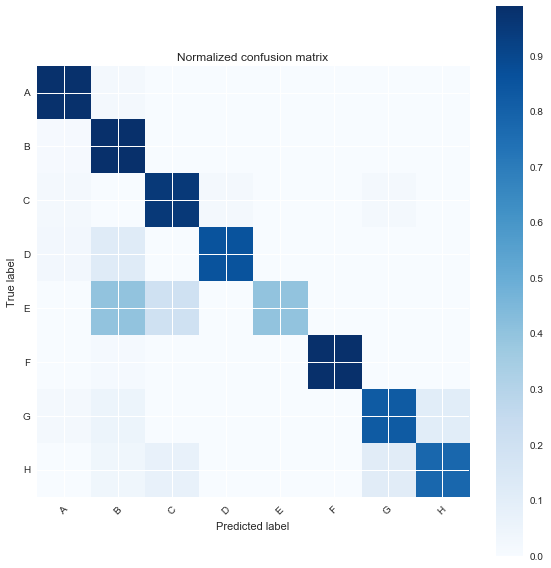

In [21]:
tfidf_model_evaluation.confusion_matrix()

## Squared Hinge Loss

In [22]:
squared_hinge = clf.multinomial_SGD_clf(
    "squared_hinge", n_iter=10, shuffle=True, learning_rate='optimal', class_weight="balanced", average=False)
tfidf_model_evaluation.cross_val_grid_search(squared_hinge, "f1_weighted", cv = 5)


* Cross-Validation & Grid Search

Fitting 5 folds for each of 9 candidates, totalling 45 fits

* Matrix Sparsity

dimensionality: 10416
density: 0.348574

* Feature Importants

top 10 keywords per class:
A: expects, results, profit, cts, loss, split, vs, profits, earnings, dividend
B: coastal, buy, takeover, sell, purchase, acquire, acquired, stake, merger, ...
C: import, subsidies, volcker, stand, export, goods, comecon, eep, surplus, t...
D: tehran, dead, handle, missiles, shipping, freights, cranes, port, ships, dwt
E: improve, cool, farm, grains, amstutz, certificates, grain, floor, harvest,...
F: pancanadian, barrels, fitzwater, ecuador, canterra, north, crude, chevron,...
G: favours, policies, gradual, bundesbank, tomorrow, customer, mo, prime, rat...
H: forint, nations, balances, account, currencies, exchange, money, dollar, c...


* Best Model Results

Best score: 0.959
Best parameters set:
	alpha: 1e-06
	penalty: 'elasticnet'

* Grid Search

Grid scores on training set:

0.92

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.9s finished


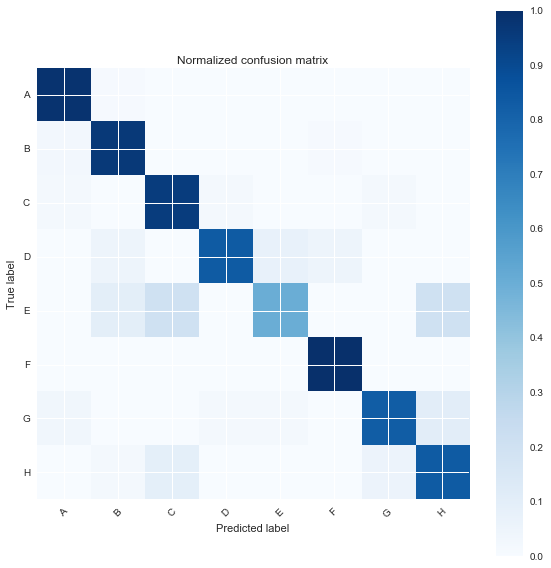

In [23]:
tfidf_model_evaluation.confusion_matrix()